<a href="https://colab.research.google.com/github/monarkparekh/MAE-598__Design-Optimization/blob/Project-1/MAE_598__Design_Optimization_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Things to Do: 
Here is a list of things we discussed during the class that could help to make the problem more representative of the reality:

1) More realistic definition of state and action spaces: Rocket orientation, angular velocity, etc. <br>
2) Better dynamical model, e.g., drag <br>
3) Constraints in state and action spaces <br>
4) Controller design for a distribution of initial states rather than one
<br>5) Randomness in dynamics, sensing, etc.

**Importing the necessary Libraries**

In [69]:
import logging
import math
import random
import numpy as np
import time
import torch 
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

**Defining the Envrionment Paramerters**

In [70]:
'''
1) The FRAME_TIME depicts the time interval for calculations
2) GRAVITY_ACCEL_X is the gravitational accelaration in x direction 
3) GRAVITY_ACCEL_Y is the gravitational accelaration in y direction 
4) BOOST_ACCEL is the thrust constant 
'''
FRAME_TIME = 0.1  
GRAVITY_ACCEL_X = 0.
GRAVITY_ACCEL_Y = 0.12  
BOOST_ACCEL = 0.18  

**Defining the System Dynamics**

In [92]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        Here the system state is defined by 5 parameters: 
          1) "x"     -----> The displacement of the rocket in x-direction
          2) "y"     -----> The displacement of the rocket in y-direction
          3) "x_dot" -----> The velocity of the rocket in x-direction
          4) "y_dot" -----> The velocity of the rocket in y-direction
          5) "theta" -----> The angle of rotation of the rocket about its center of mass

        The array "state" stores the five system states defined above.
        state[0] = x
        state[1] = y
        state[2] = x_dot
        state[3] = y_dot
        state[4] = theta

        Whereas, the control actions comprise of:
          1) "thrust" ----> The Force produced by the rocket propulsion
          2) "theta_dot" -> The angular velocity of the rocket about its center of mass

        The array "action" stores the two control actions defined above.
        action[0] = thrust 
        action[1] = theta_dot
        """

        # Here "-GRAVITY_ACCEL_X * FRAME_TIME" depicts the effect of gravity in x direction, and
        # "-GRAVITY_ACCEL_Y * FRAME_TIME" depicts the effect of gravity in y direction.
        delta_state_gravity = torch.tensor([0., 0.,-GRAVITY_ACCEL_X * FRAME_TIME, -GRAVITY_ACCEL_Y * FRAME_TIME, 0.])

        # Calculating the Thrust for the given state
        state_tensor = torch.zeros((1, 5))
        state_tensor[0, 2] = torch.cos(state[0, 4])
        state_tensor[0, 3] = torch.sin(state[0, 4])

        delta_state = BOOST_ACCEL * FRAME_TIME * torch.mul(state_tensor, action[0, 0].reshape(-1, 1))

        # Calculating the Theta for the given state and action 
        delta_state_theta = FRAME_TIME * torch.mul(torch.tensor([0., 0., 0., 0, 1.]),(action[0, 1]).reshape(-1, 1)) 
    
        state = state + delta_state  + delta_state_gravity + delta_state_theta

        # Updating the state based on the Frame Time
        step_mat = torch.tensor([[1., 0.,FRAME_TIME, 0., 0.],
                                 [0., 1., 0., FRAME_TIME, 0.],
                                 [0., 0., 1.,0., 0.],
                                 [0., 0., 0., 1., 0.],
                                 [0., 0., 0., 0., 1.]])

        state = torch.matmul(step_mat, state.T)     
        return state.T

**Defining the System Controller**

In [145]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input:  Number of system states
        dim_output: Number of actions
        dim_hidden: Number of hidden layers
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid(),
            nn.Linear(dim_output, dim_input),
            nn.Tanh(),
            nn.Linear(dim_input, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        # Bounding the "theta_dot" in the range of -1 to 1
        action = self.network(state)
        action = (2*action - torch.tensor([0., 1])) 
        return action

In [146]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [[1.,1.,0.,0.,0.]]
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):
    
        return torch.mean(state ** 2)

In [149]:
class Optimize:    
    def __init__(self, simulation):
        self.simulation = simulation # Defining the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.007) # Defining the opmization algorithm
        self.loss_list = []

    # Defining the loss calculation method for objective function
    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()

    # Defining the training method for the model
    def train(self, epochs):
        l = np.zeros(epochs)
        for epoch in range(epochs):
            loss = self.step() 
            self.loss_list.append(loss) 
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            l[epoch]=loss
            
        plt.plot(list(range(epochs)), l)       
        plt.title('Convergence Curve of the Objective Function')
        plt.xlabel('Iteration')
        plt.ylabel('Function Error')
        plt.show()
        self.visualize()
        
        
    # Plotting the states
    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:,0]
        y = data[:,1]
        vx = data[:,2]
        vy = data[:,3]
        theta = data[:,4]

        plt.plot(x, y)
        plt.title("Postion X w.r.t to Postion Y ")
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()

        plt.plot(vx, x)
        plt.title("Change of X w.r.t Velocity in X ")
        plt.xlabel('vx')
        plt.ylabel('x')
        plt.show()

        plt.plot(vy, y)
        plt.title("Change of Y w.r.t Velocity in Y ")
        plt.xlabel('vy')
        plt.ylabel('y')
        plt.show()

        plt.plot(y,theta)
        plt.title("Change of Theta w.r.t to Postion in Y ")
        plt.ylabel('theta')
        plt.xlabel('y')
        plt.show()

        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        thrust = action_data[:,0]
        theta_dot = action_data[:,0]

[1] loss: 11.777
[2] loss: 8.643
[3] loss: 7.183
[4] loss: 6.330
[5] loss: 5.797
[6] loss: 5.447
[7] loss: 5.202
[8] loss: 5.021
[9] loss: 4.881
[10] loss: 4.762
[11] loss: 4.639
[12] loss: 4.336
[13] loss: 3.584
[14] loss: 2.282
[15] loss: 0.940
[16] loss: 0.640
[17] loss: 0.507
[18] loss: 0.394
[19] loss: 0.286
[20] loss: 0.204
[21] loss: 0.145
[22] loss: 0.101
[23] loss: 0.068
[24] loss: 0.045
[25] loss: 0.032
[26] loss: 0.025
[27] loss: 0.020
[28] loss: 0.015
[29] loss: 0.012
[30] loss: 0.009
[31] loss: 0.007
[32] loss: 0.005
[33] loss: 0.004
[34] loss: 0.003
[35] loss: 0.002
[36] loss: 0.002
[37] loss: 0.001
[38] loss: 0.001
[39] loss: 0.001
[40] loss: 0.000
[41] loss: 0.000
[42] loss: 0.000
[43] loss: 0.000
[44] loss: 0.000
[45] loss: 0.000
[46] loss: 0.000
[47] loss: 0.000
[48] loss: 0.000
[49] loss: 0.000
[50] loss: 0.000
[51] loss: 0.000
[52] loss: 0.000
[53] loss: 0.000
[54] loss: 0.000
[55] loss: 0.000
[56] loss: 0.000
[57] loss: 0.000
[58] loss: 0.000
[59] loss: 0.000
[60] 

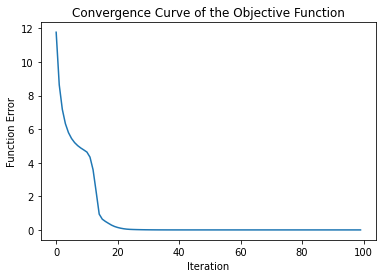

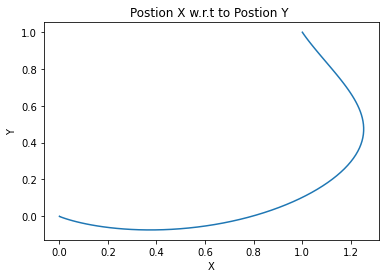

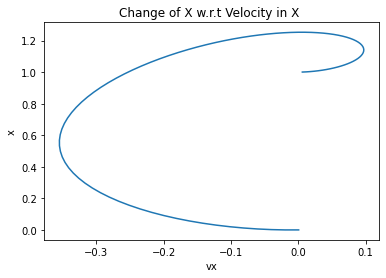

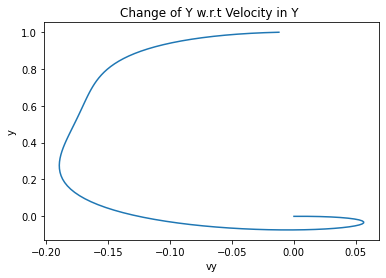

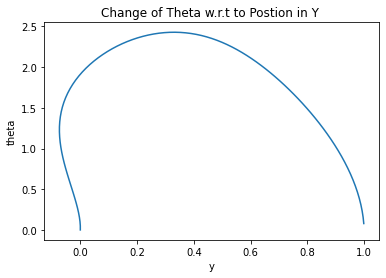

In [150]:
T = 100  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 12  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  
c = Controller(dim_input, dim_hidden, dim_output)  
s = Simulation(c, d, T)  
o = Optimize(s)  
o.train(100)  # training with number of epochs